#### Pretraitement les données

1-1 : Suppression des images et masques vides ou noirs

In [ ]:
#!/usr/bin/env python3
import os
import cv2

# ───── CONFIG ─────
ROOT      = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset"
SPLITS    = ["train", "val"]
IMG_SUB   = "img"
MASK_SUB  = "mask"   
EXTS      = (".png", ".jpg", ".jpeg")

# ───── RUN ─────
total_deleted = 0

for split in SPLITS:
    img_dir  = os.path.join(ROOT, split, IMG_SUB)
    mask_dir = os.path.join(ROOT, split, MASK_SUB)
    split_deleted = 0

    print(f"\nScanning `{split}`...")
    for fn in sorted(os.listdir(img_dir)):
        if not fn.lower().endswith(EXTS):
            continue

        img_path = os.path.join(img_dir, fn)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue

        # check if all channels are zero
        if not img.any():
            # delete image
            os.remove(img_path)
            # delete corresponding mask (same basename, .png)
            mask_fn = os.path.splitext(fn)[0] + ".png"
            mask_path = os.path.join(mask_dir, mask_fn)
            if os.path.exists(mask_path):
                os.remove(mask_path)

            split_deleted += 1
            total_deleted += 1

    print(f"→ `{split}`: deleted {split_deleted} images")
print(f"\n✅ Done. Tot..al images removed: {total_deleted}")



Scanning `train`...
→ `train`: deleted 150 images

Scanning `val`...
→ `val`: deleted 30 images

✅ Done. Total images removed: 180


1-2 : resize image et normalisation au 512 * 96 pixels 

In [17]:
#!/usr/bin/env python3
import os
import cv2
from tqdm import tqdm

# ───── EDIT THESE ─────
ROOT         = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset"
SPLITS       = ["train", "val"]
IMG_SUB      = "img"     # name of your subfolder containing images
MASK_SUB     = "mask"    # name of your subfolder containing masks
TARGET_WIDTH = 512       # desired width
TARGET_HEIGHT= 256       # desired height
# ──────────────────────

def resize_folder(src_dir, is_mask=False):
    """Resize all images in src_dir to (TARGET_WIDTH, TARGET_HEIGHT)."""
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    bar = tqdm(files, desc=f" Resizing {'masks' if is_mask else 'images'} in {os.path.basename(src_dir)}", ncols=80)
    for fn in bar:
        path = os.path.join(src_dir, fn)
        # for masks we want to keep the pixel values exact, so read UNCHANGED
        flag = cv2.IMREAD_UNCHANGED if is_mask else cv2.IMREAD_COLOR
        img = cv2.imread(path, flag)
        if img is None:
            bar.write(f" ⚠️  failed to read {path}")
            continue

        # pick interpolation
        interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        resized = cv2.resize(img, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=interp)
        cv2.imwrite(path, resized)

if __name__ == "__main__":
    for split in SPLITS:
        img_dir  = os.path.join(ROOT, split, IMG_SUB)
        mask_dir = os.path.join(ROOT, split, MASK_SUB)
        if not os.path.isdir(img_dir):
            print(f"⚠️  Missing image folder: {img_dir}")
        else:
            resize_folder(img_dir, is_mask=False)

        if not os.path.isdir(mask_dir):
            print(f"⚠️  Missing mask folder: {mask_dir}")
        else:
            resize_folder(mask_dir, is_mask=True)

    print("✅ All splits resized to "
          f"{TARGET_WIDTH}×{TARGET_HEIGHT} px.")


 Resizing masks in mask: 100%|████████████████| 500/500 [00:15<00:00, 31.70it/s]

✅ All splits resized to 512×256 px.


1-3 data augmentaion 

Augmenting: 100%|█████████████████| 2975/2975 [24:12<00:00,  2.05it/s]



✅ Wrote originals + 5 augmentations per image:
   → Images: C:/Users/MBQ/Desktop/ML Projet Test/Ptojet_ML_Yolo/dataset\train_aug\img
   → Masks:  C:/Users/MBQ/Desktop/ML Projet Test/Ptojet_ML_Yolo/dataset\train_aug\mask


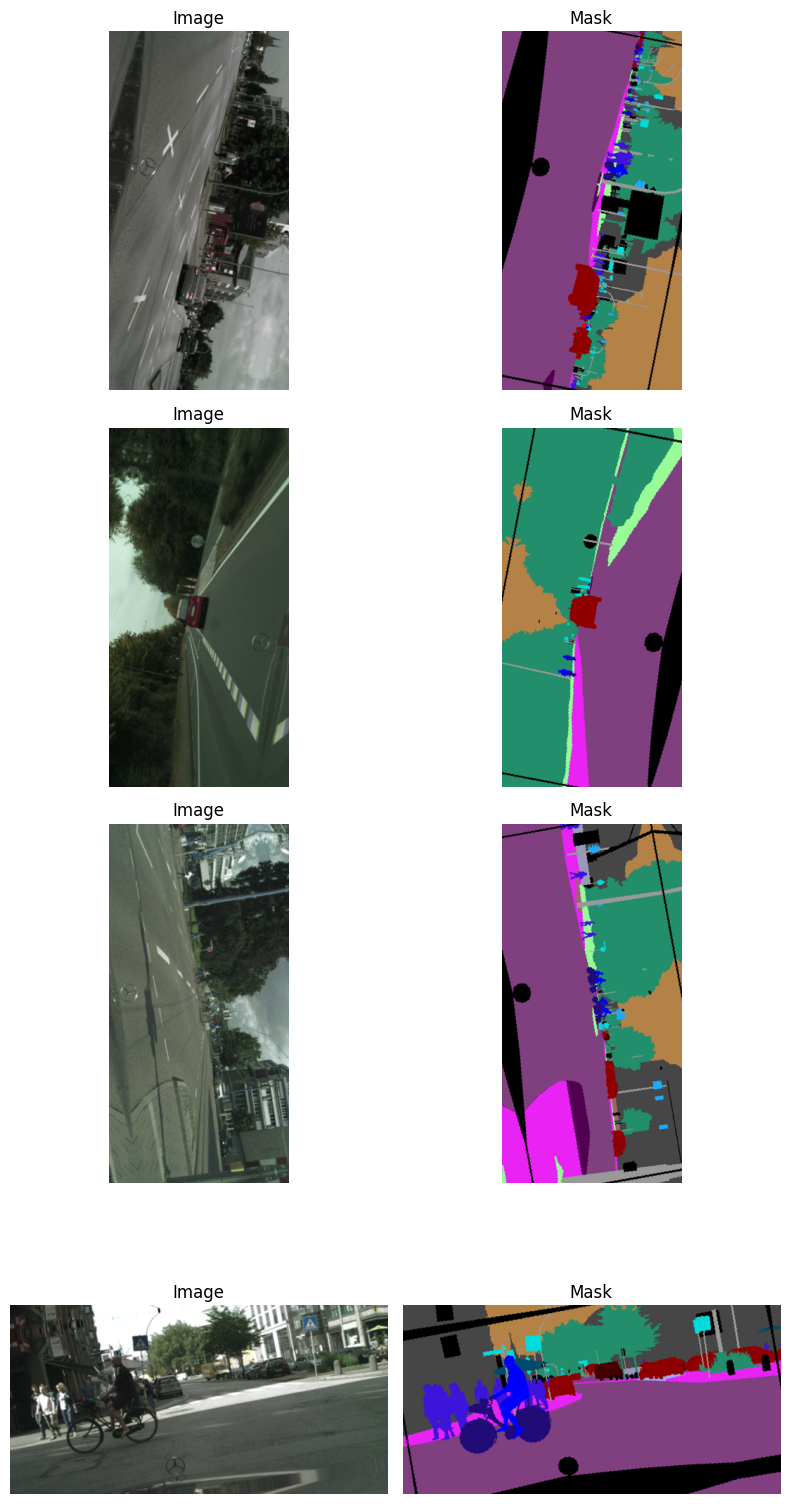

In [24]:
#!/usr/bin/env python3
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90,
    Rotate, RandomBrightnessContrast, HueSaturationValue,
    GaussNoise, GaussianBlur
)

# ───── CONFIG ─────
ROOT        = r"C:/Users/MBQ/Desktop/ML Projet Test/Ptojet_ML_Yolo/dataset"
IN_IMG_DIR  = os.path.join(ROOT, "train", "img")
IN_MSK_DIR  = os.path.join(ROOT, "train", "mask")
OUT_IMG_DIR = os.path.join(ROOT, "train_aug", "img")
OUT_MSK_DIR = os.path.join(ROOT, "train_aug", "mask")
N_AUGS      = 5  # how many variants per image

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_MSK_DIR, exist_ok=True)

# ───── AUGMENTATION PIPELINE ─────
augs = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.2),
    RandomRotate90(p=0.5),                           # 0°, 90°, 180°, 270°
    Rotate(limit=15, border_mode=cv2.BORDER_REFLECT, p=0.7),  # small random rotates
    RandomBrightnessContrast(brightness_limit=0.2,
                             contrast_limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=15,
                       sat_shift_limit=25,
                       val_shift_limit=15, p=0.5),
    GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    GaussianBlur(blur_limit=(3,7), p=0.2),
])

def load_pair(filename):
    base = os.path.splitext(filename)[0]
    img  = cv2.imread(os.path.join(IN_IMG_DIR, filename), cv2.IMREAD_COLOR)
    msk  = cv2.imread(os.path.join(IN_MSK_DIR, base + ".png"), cv2.IMREAD_UNCHANGED)
    if img is None or msk is None:
        raise FileNotFoundError(f"Missing {filename} or its mask")
    return base, img, msk

def save_pair(base, tag, img, msk):
    name = f"{base}_aug{tag}.png"
    cv2.imwrite(os.path.join(OUT_IMG_DIR, name), img)
    cv2.imwrite(os.path.join(OUT_MSK_DIR, name), msk)

# ───── RUN AUGMENTATION ─────
files = sorted(f for f in os.listdir(IN_IMG_DIR) if f.lower().endswith(".png"))
for fn in tqdm(files, desc="Augmenting", ncols=70):
    base, img, msk = load_pair(fn)
    # always save the original alongside
    save_pair(base, "orig", img, msk)
    # generate N_AUGS variants
    for i in range(N_AUGS):
        out = augs(image=img, mask=msk)
        save_pair(base, i, out["image"], out["mask"])

print(f"\n✅ Wrote originals + {N_AUGS} augmentations per image:")
print("   → Images:", OUT_IMG_DIR)
print("   → Masks: ", OUT_MSK_DIR)

# ───── DISPLAY 4 RANDOM PAIRS ─────
aug_files = [f for f in os.listdir(OUT_IMG_DIR) if "_augorig" not in f]
sample    = random.sample(aug_files, min(4, len(aug_files)))

fig, axes = plt.subplots(len(sample), 2, figsize=(8, 4*len(sample)))
for i, fname in enumerate(sample):
    img = cv2.cvtColor(cv2.imread(os.path.join(OUT_IMG_DIR, fname)), cv2.COLOR_BGR2RGB)
    msk = cv2.imread(os.path.join(OUT_MSK_DIR, fname), cv2.IMREAD_UNCHANGED)
    axes[i,0].imshow(img)
    axes[i,0].axis("off")
    axes[i,0].set_title("Image")
    axes[i,1].imshow(msk, cmap="gray")
    axes[i,1].axis("off")
    axes[i,1].set_title("Mask")
plt.tight_layout()
plt.show()


1-3 Conversion des masques one-hot encodés (image gris)

In [ ]:
# color2id_masks.py
Ptojet_ML_Yolo
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# ───── CONFIG ─────
DATA_ROOT    = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset"
SPLITS       = ["train", "val"]
COLOR_SUBDIR = "mask"   # where your original color masks live
OUT_SUBDIR   = "labels"  # where we’ll write the 1-ch masks

# your original color → class-ID map
PALETTE = {
    (  0,   0,   0):  0,  # static
    (111,  74,   0):  7,  # dynamic
    ( 81,   0,  81):  6,  # ground
    (128,  64, 128):  1,  # road
    (244,  35, 232):  1,  # sidewalk→ merge→1
    (250, 170, 160):  1,  # parking→ merge→1
    (230, 150, 140):  1,  # rail track→ merge→1
    ( 70,  70,  70):  5,  # building→structure→5
    (102, 102, 156):  5,  # wall→structure→5
    (190, 153, 153):  5,  # fence→structure→5
    (180, 165, 180):  5,  # guard rail→structure→5
    (150, 100, 100):  5,  # bridge→structure→5
    (150, 120,  90):  5,  # tunnel→structure→5
    (153, 153, 153):  4,  # pole
    (250, 170,  30):  2,  # traffic light→traffic→2
    (220, 220,   0):  2,  # traffic sign→traffic→2
    (220,  20,  60):  3,  # person
    (255,   0,   0):  3,  # rider→person→3
    (  0,   0, 142):  4,  # car→vehicle→4
    (  0,   0,  70):  4,  # truck→vehicle→4
    (  0,  60, 100):  4,  # bus→vehicle→4
    (  0,   0,  90):  4,  # caravan→vehicle→4
    (  0,   0, 110):  4,  # trailer→vehicle→4
    (  0,  80, 100):  4,  # train→vehicle→4
    (  0,   0, 230):  4,  # motorcycle→vehicle→4
    (119,  11,  32):  4,  # bicycle→vehicle→4
    (107, 142,  35):  8,  # vegetation
    (152, 251, 152):  9,  # terrain
    ( 70, 130, 180): 10,  # sky
}

# ───── FUNCTION ─────
def convert_split(split):
    color_dir = os.path.join(DATA_ROOT, split, COLOR_SUBDIR)
    out_dir   = os.path.join(DATA_ROOT, split, OUT_SUBDIR)
    os.makedirs(out_dir, exist_ok=True)

    files = [f for f in os.listdir(color_dir) if f.lower().endswith((".png",".jpg"))]
    for fn in tqdm(files, desc=f"[{split}]", unit="img"):
        img = np.array(Image.open(os.path.join(color_dir, fn)).convert("RGB"))
        h,w,_ = img.shape
        id_mask = np.zeros((h,w), dtype=np.uint8)

        # for each palette entry, mask==color → id
        for color, cid in PALETTE.items():
            matches = np.all(img == color, axis=-1)
            id_mask[matches] = cid

        # any pixel that didn’t match → leave 0 or set to some “ignore” id
        out_path = os.path.join(out_dir, fn)
        Image.fromarray(id_mask).save(out_path)

    print(f"[{split}] done → {out_dir}")

# ───── MAIN ─────
if __name__ == "__main__":
    for s in SPLITS:
        convert_split(s)


[train]: 100%|██████████| 2975/2975 [25:38<00:00,  1.93img/s]


[train] done → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\maskss


[val]: 100%|██████████| 500/500 [03:36<00:00,  2.31img/s]

[val] done → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\val\maskss


1-3 teste la Conversion des masques one-hot encodés (image gris)

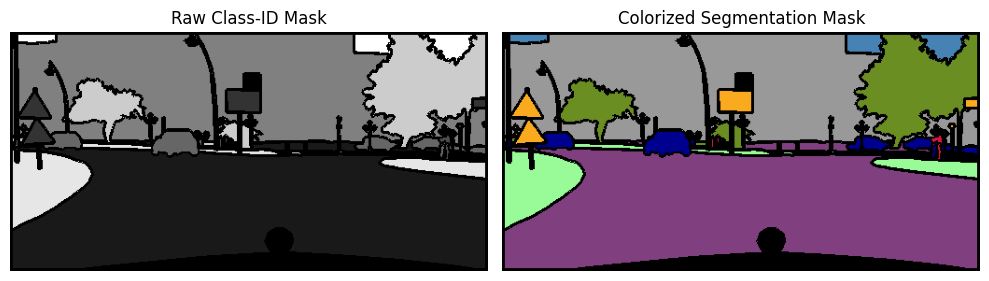

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ───── CONFIG ─────
MASK_PATH = r"dataset/train/maskss/train 1.png"  # your one‐channel mask
PALETTE = {
    0: (  0,   0,   0),  # static
    1: (128,  64, 128),  # road_sidewalk_parking
    2: (250, 170,  30),  # traffic
    3: (220,  20,  60),  # person
    4: (  0,   0, 142),  # vehicle
    5: (153, 153, 153),  # pole
    6: ( 70,  70,  70),  # structure
    7: ( 81,   0,  81),  # ground
    8: (107, 142,  35),  # vegetation
    9: (152, 251, 152),  # terrain
   10: ( 70, 130, 180),  # sky
}

# ───── LOAD MASK ─────
# read as grayscale (so pixel values = class IDs)
mask = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError(f"Could not load mask at {MASK_PATH!r}")

h, w = mask.shape

# ───── COLORIZE ─────
color_mask = np.zeros((h, w, 3), dtype=np.uint8)
for cls_id, rgb in PALETTE.items():
    color_mask[mask == cls_id] = rgb  # broadcast to RGB

# ───── DISPLAY ─────
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# raw (gray) mask
axs[0].imshow(mask, cmap="gray", vmin=0, vmax=max(PALETTE.keys()))
axs[0].set_title("Raw Class‐ID Mask")
axs[0].axis("off")

# colorized mask
axs[1].imshow(color_mask)
axs[1].set_title("Colorized Segmentation Mask")
axs[1].axis("off")

plt.tight_layout()
plt.show()


1-4 Conversion one-hot encodés à yolo format txt

1-4 teste la Conversion one-hot encodés à yolo format txt

In [ ]:
#!/usr/bin/env python3
import os
import cv2
import numpy as np

# ───── CONFIG ─────
ROOT   = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset"
SPLITS = ["train", "val"]
IMG_SUB  = "img"      # your images live in dataset/<split>/img
MASK_SUB = "mask"     # your color‐masks live in dataset/<split>/mask

# ───── YOUR PALETTE (RGB→ID) ─────
PALETTE = {
    (  0,   0,   0):  0,  # static / background
    (111,  74,   0):  7,  # dynamic
    ( 81,   0,  81):  6,  # ground
    (128,  64, 128):  1,  # road
    (244,  35, 232):  1,  # sidewalk→road
    (250, 170, 160):  1,  # parking→road
    (230, 150, 140):  1,  # rail track→road
    ( 70,  70,  70):  5,  # building→structure
    (102, 102, 156):  5,  # wall→structure
    (190, 153, 153):  5,  # fence→structure
    (180, 165, 180):  5,  # guard rail→structure
    (150, 100, 100):  5,  # bridge→structure
    (150, 120,  90):  5,  # tunnel→structure
    (153, 153, 153):  4,  # pole
    (250, 170,  30):  2,  # traffic light→traffic
    (220, 220,   0):  2,  # traffic sign→traffic
    (220,  20,  60):  3,  # person
    (255,   0,   0):  3,  # rider→person
    (  0,   0, 142):  4,  # car→vehicle
    (  0,   0,  70):  4,  # truck→vehicle
    (  0,  60, 100):  4,  # bus→vehicle
    (  0,   0,  90):  4,  # caravan→vehicle
    (  0,   0, 110):  4,  # trailer→vehicle
    (  0,  80, 100):  4,  # train→vehicle
    (  0,   0, 230):  4,  # motorcycle→vehicle
    (119,  11,  32):  4,  # bicycle→vehicle
    (107, 142,  35):  8,  # vegetation
    (152, 251, 152):  9,  # terrain
    ( 70, 130, 180): 10,  # sky
}

for split in SPLITS:
    img_dir = os.path.join(ROOT, split, IMG_SUB)
    msk_col = os.path.join(ROOT, split, MASK_SUB)
    msk_id  = os.path.join(ROOT, split, "masks_id")  # ← will be created
    os.makedirs(msk_id, exist_ok=True)

    print(f"\n=== SPLIT: {split} ===")
    for fn in sorted(os.listdir(img_dir)):
        if not fn.lower().endswith((".png","jpg","jpeg")):
            continue

        name, _ = os.path.splitext(fn)
        col_path = os.path.join(msk_col, name + ".png")
        id_path  = os.path.join(msk_id,  name + ".png")
        txt_path = os.path.join(img_dir, name + ".txt")

        if not os.path.exists(col_path):
            print(f"⚠️  no mask for {fn}, skipping.")
            open(txt_path,"w").close()
            continue

        # — Convert color→ID mask
        col = cv2.imread(col_path, cv2.IMREAD_COLOR)            # BGR
        col = cv2.cvtColor(col, cv2.COLOR_BGR2RGB)              # → RGB
        h, w = col.shape[:2]
        idm  = np.zeros((h,w), dtype=np.uint8)

        # vectorized: for each palette entry, paint those pixels
        for rgb, cid in PALETTE.items():
            mask = np.all(col == rgb, axis=2)
            idm[mask] = cid

        cv2.imwrite(id_path, idm)

        # — Extract polygons & write YOLO-Seg .txt
        lines = []
        for cls_id in np.unique(idm):
            if cls_id == 0:  # skip background
                continue
            binm = (idm == cls_id).astype(np.uint8)
            cnts,_ = cv2.findContours(binm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in cnts:
                # no area threshold → tiny poles & people included
                pts = cv2.approxPolyDP(cnt, 0.001*cv2.arcLength(cnt,True), True).reshape(-1,2)
                coords = []
                for x,y in pts:
                    coords += [f"{x/w:.6f}", f"{y/h:.6f}"]
                lines.append(" ".join([str(int(cls_id))] + coords))

        with open(txt_path, "w") as f:
            f.write("\n".join(lines))

        print(f" • {fn}: mask-ID saved, {len(lines)} polys → {txt_path}")

    print(f"→ done split={split} (ID masks in `{msk_id}`)\n")



=== SPLIT: train ===
 • train 1.png: mask-ID saved, 97 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 1.txt
 • train 10.png: mask-ID saved, 90 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 10.txt
 • train 100.png: mask-ID saved, 104 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 100.txt
 • train 1000.png: mask-ID saved, 47 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 1000.txt
 • train 1001.png: mask-ID saved, 70 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 1001.txt
 • train 1002.png: mask-ID saved, 124 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 1002.txt
 • train 1003.png: mask-ID saved, 97 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset\train\img\train 1003.txt
 • train 1004.png: mask-ID saved, 78 polys → C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/datas

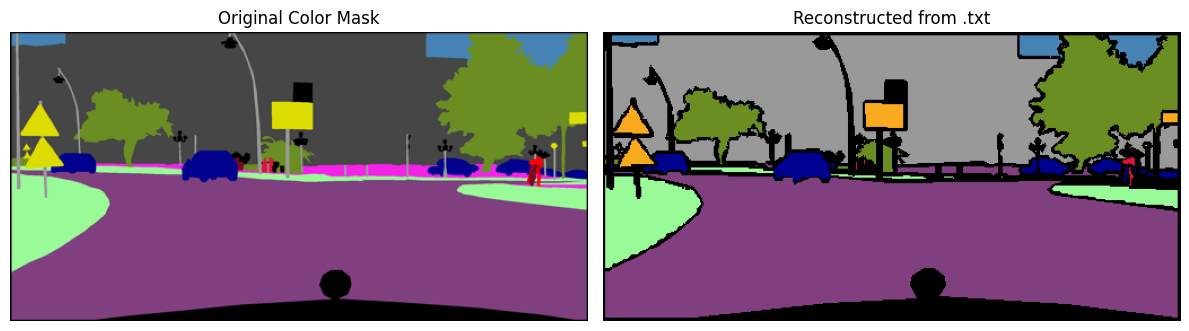

In [7]:
# recon_verify.py

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# ───── CONFIG ─────
ORIG_MASK = r"dataset/train/mask/train 1.png"   # ← your original color mask
TXT_MASK  = r"dataset/train/img/train 1.txt"  # ← your generated YOLO-Seg .txt

# Your exact merge-class palette (RGB)
PALETTE = {
    0: (  0,   0,   0),  # static
    1: (128,  64, 128),  # road_sidewalk_parking
    2: (250, 170,  30),  # traffic
    3: (220,  20,  60),  # person
    4: (  0,   0, 142),  # vehicle
    5: (153, 153, 153),  # pole
    6: ( 70,  70,  70),  # structure
    7: ( 81,   0,  81),  # ground
    8: (107, 142,  35),  # vegetation   ← this is your “tree” green
    9: (152, 251, 152),  # terrain
   10: ( 70, 130, 180),  # sky
}

# ───── LOAD ORIGINAL ─────
orig_color = np.array(Image.open(ORIG_MASK).convert("RGB"))
h, w = orig_color.shape[:2]

# ───── RECONSTRUCT FROM TXT ─────
mask = np.zeros((h, w), dtype=np.uint8)

with open(TXT_MASK) as f:
    for line in f:
        parts = line.strip().split()
        cls   = int(parts[0])
        coords = list(map(float, parts[1:]))
        # denormalize
        pts = np.array(coords).reshape(-1, 2)
        pts[:,0] *= w
        pts[:,1] *= h
        pts = pts.astype(np.int32)
        cv2.fillPoly(mask, [pts], cls)

# colorize reconstructed mask
recon_color = np.zeros((h, w, 3), dtype=np.uint8)
for cls_id, rgb in PALETTE.items():
    recon_color[mask == cls_id] = rgb

# ───── PLOT SIDE BY SIDE ─────
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(orig_color)
axes[0].set_title("Original Color Mask")
axes[0].axis("off")

axes[1].imshow(recon_color)
axes[1].set_title("Reconstructed from .txt")
axes[1].axis("off")

plt.tight_layout()
plt.show()


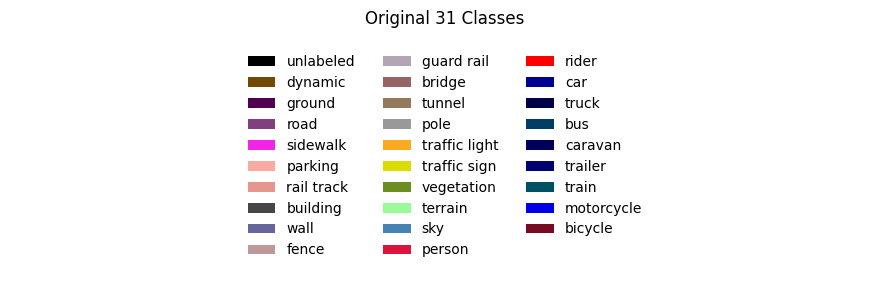

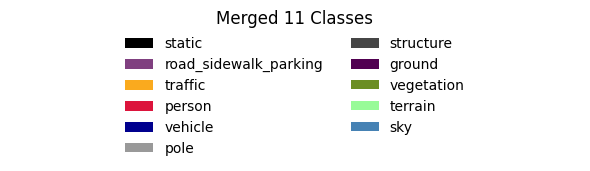

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── 1) your original 31 classes ─────────────────────────────────────────────
original_class_colors = {
    "unlabeled":         (  0,   0,   0),
    "dynamic":           (111,  74,   0),
    "ground":            ( 81,   0,  81),
    "road":              (128,  64, 128),
    "sidewalk":          (244,  35, 232),
    "parking":           (250, 170, 160),
    "rail track":        (230, 150, 140),
    "building":          ( 70,  70,  70),
    "wall":              (102, 102, 156),
    "fence":             (190, 153, 153),
    "guard rail":        (180, 165, 180),
    "bridge":            (150, 100, 100),
    "tunnel":            (150, 120,  90),
    "pole":              (153, 153, 153),
    "traffic light":     (250, 170,  30),
    "traffic sign":      (220, 220,   0),
    "vegetation":        (107, 142,  35),
    "terrain":           (152, 251, 152),
    "sky":               ( 70, 130, 180),
    "person":            (220,  20,  60),
    "rider":             (255,   0,   0),
    "car":               (  0,   0, 142),
    "truck":             (  0,   0,  70),
    "bus":               (  0,  60, 100),
    "caravan":           (  0,   0,  90),
    "trailer":           (  0,   0, 110),
    "train":             (  0,  80, 100),
    "motorcycle":        (  0,   0, 230),
    "bicycle":           (119,  11,  32),
    # add any others you have…
}

# ─── 2) your merged 11 classes ────────────────────────────────────────────────
merged_class_colors = {
    "static":                (  0,   0,   0),
    "road_sidewalk_parking": (128,  64, 128),
    "traffic":               (250, 170,  30),
    "person":                (220,  20,  60),
    "vehicle":               (  0,   0, 142),
    "pole":                  (153, 153, 153),
    "structure":             ( 70,  70,  70),
    "ground":                ( 81,   0,  81),
    "vegetation":            (107, 142,  35),
    "terrain":               (152, 251, 152),
    "sky":                   ( 70, 130, 180),
}

def plot_legend(color_map, title, cols=2):
    """Draw a vertical legend for the given {name: RGB} map."""
    # normalize to [0–1]
    patches = [Patch(facecolor=[c/255 for c in rgb], label=name)
               for name, rgb in color_map.items()]
    # figure size driven by number of entries
    rows = (len(patches) + cols - 1) // cols
    fig, ax = plt.subplots(figsize=(3*cols, 0.3*rows))
    ax.legend(handles=patches,
              ncol=cols,
              loc="center",
              frameon=False)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_legend(original_class_colors, "Original 31 Classes", cols=3)
    plot_legend(merged_class_colors,   "Merged 11 Classes",   cols=2)


## From Scratch Unet

Starting advanced U-Net training with validation and data augmentation at 128x48 resolution...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 48, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 48, 32)          896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 48, 32)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  

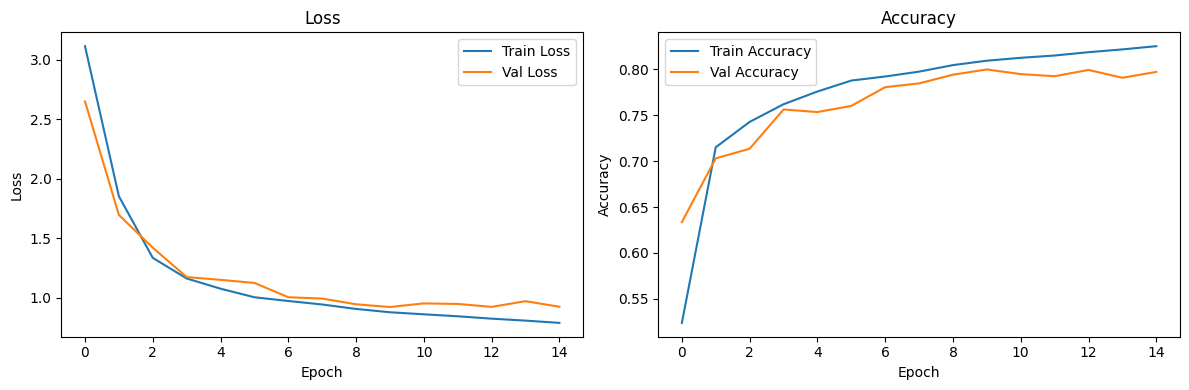

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import gc

# FREE MEMORY AGGRESSIVELY
gc.collect()
tf.keras.backend.clear_session()

# -------------------------
# 1) CONFIGURATION
# -------------------------
# Use reduced resolution for speed: 128 x 48
IMG_HEIGHT = 128
IMG_WIDTH  = 48
# Update NUM_CLASSES according to your object colors (e.g. 31 previously, update as needed)
NUM_CLASSES = 31  

BATCH_SIZE = 8       # Adjust based on your hardware
EPOCHS = 50
LEARNING_RATE = 5e-4
PATIENCE = 5
USE_CACHE = True      # Cache datasets in memory

# For this example, we keep the same object_colors mapping you provided.
object_colors = {
    'static': (0, 0, 0),
    'dynamic': (111, 74, 0),
    'ground': (81, 0, 81),
    'road': (128, 64, 128),
    'sidewalk': (244, 35, 232),
    'parking': (250, 170, 160),
    'rail track': (230, 150, 140),
    'building': (70, 70, 70),
    'wall': (102, 102, 156),
    'fence': (190, 153, 153),
    'guard rail': (180, 165, 180),
    'bridge': (150, 100, 100),
    'tunnel': (150, 120, 90),
    'pole': (153, 153, 153),
    'polegroup': (153, 153, 153),
    'traffic light': (250, 170, 30),
    'traffic sign': (220, 220, 0),
    'vegetation': (107, 142, 35),
    'terrain': (152, 251, 152),
    'sky': (70, 130, 180),
    'person': (220, 20, 60),
    'rider': (255, 0, 0),
    'car': (0, 0, 142),
    'truck': (0, 0, 70),
    'bus': (0, 60, 100),
    'caravan': (0, 0, 90),
    'trailer': (0, 0, 110),
    'train': (0, 80, 100),
    'motorcycle': (0, 0, 230),
    'bicycle': (119, 11, 32),
    'license plate': (0, 0, 142)
}

# Generate mapping from RGB color to class index.
OBJECT_COLOR_MAP = {tuple(color): idx for idx, (key, color) in enumerate(object_colors.items())}
# Uniform class weights (adjust if desired)
CLASS_WEIGHTS = [1.0 for _ in range(NUM_CLASSES)]

# Directories (adjust as needed)
train_image_dir = "dataset/train/img"
train_mask_dir  = "dataset/train/mask"
val_image_dir   = "dataset/val/img"
val_mask_dir    = "dataset/val/mask"
checkpoint_dir  = "model2"
os.makedirs(checkpoint_dir, exist_ok=True)

# -------------------------
# 2) DATA LOADING AND PREPROCESSING
# -------------------------
def convert_mask_numpy(mask):
    """
    Convert an RGB mask (numpy array) to a one-hot encoded mask based on OBJECT_COLOR_MAP.
    The mask is assumed to be resized to (IMG_HEIGHT, IMG_WIDTH).
    """
    mask = mask.astype(np.uint8)
    mask_class = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    for color, class_idx in OBJECT_COLOR_MAP.items():
        match = np.all(mask == np.array(color, dtype=np.uint8), axis=-1)
        mask_class[match] = class_idx
    mask_one_hot = np.eye(NUM_CLASSES)[mask_class]
    return mask_one_hot.astype(np.float32)

def get_dataset(image_dir, mask_dir, batch_size, augment=True):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    
    def _load_data(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
        image = tf.cast(image, tf.float32) / 255.0
        
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=3)
        mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.numpy_function(func=convert_mask_numpy, inp=[mask], Tout=tf.float32)
        mask.set_shape((IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES))
        return image, mask
    
    dataset = dataset.map(_load_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        def _augment(image, mask):
            # Horizontal flip
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)
            # Random brightness
            if tf.random.uniform(()) > 0.5:
                image = tf.image.random_brightness(image, 0.1)
                image = tf.clip_by_value(image, 0.0, 1.0)
            return image, mask
        dataset = dataset.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.shuffle(buffer_size=min(1000, len(image_files)))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# -------------------------
# 3) COMBINED LOSS FUNCTIONS
# -------------------------
def weighted_categorical_crossentropy():
    weights = tf.constant(CLASS_WEIGHTS, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        weighted_losses = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(weighted_losses, axis=-1)
        return tf.reduce_mean(loss)
    return loss_fn

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def combined_loss():
    def loss(y_true, y_pred):
        return weighted_categorical_crossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# -------------------------
# 4) ADVANCED U-NET ARCHITECTURE
# -------------------------
def advanced_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(input_size)
    
    # Encoder: Block 1
    conv1 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)  # shape: 64x24
    
    # Encoder: Block 2
    conv2 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)  # shape: 32x12
    
    # Encoder: Block 3
    conv3 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)  # shape: 16x6
    
    # Bottleneck
    conv4 = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    
    # Decoder: Block 1
    up1 = layers.UpSampling2D(size=(2, 2))(drop4)
    up1 = layers.Conv2D(128, 2, padding='same', kernel_initializer='he_normal')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Activation('relu')(up1)
    merge1 = layers.Concatenate(axis=3)([conv3, up1])
    conv5 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(merge1)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    
    # Decoder: Block 2
    up2 = layers.UpSampling2D(size=(2, 2))(conv5)
    up2 = layers.Conv2D(64, 2, padding='same', kernel_initializer='he_normal')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Activation('relu')(up2)
    merge2 = layers.Concatenate(axis=3)([conv2, up2])
    conv6 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(merge2)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    
    # Decoder: Block 3
    up3 = layers.UpSampling2D(size=(2, 2))(conv6)
    up3 = layers.Conv2D(32, 2, padding='same', kernel_initializer='he_normal')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Activation('relu')(up3)
    merge3 = layers.Concatenate(axis=3)([conv1, up3])
    conv7 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(merge3)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# -------------------------
# 5) LEARNING RATE SCHEDULER (WARM-UP)
# -------------------------
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return LEARNING_RATE * (epoch + 1) / 5.0  # Warm-up over 5 epochs
    else:
        return LEARNING_RATE

lr_scheduler_cb = LearningRateScheduler(lr_scheduler)

# -------------------------
# 6) TRAINING PIPELINE WITH VALIDATION
# -------------------------
def train_advanced_model():
    # Repeat training dataset so that each epoch has enough iterations.
    train_dataset = get_dataset(train_image_dir, train_mask_dir, BATCH_SIZE, augment=True).repeat()
    # Validation dataset is not repeated.
    val_dataset   = get_dataset(val_image_dir, val_mask_dir, BATCH_SIZE, augment=False)
    
    model = advanced_unet()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=combined_loss(), metrics=['accuracy'])
    
    model.summary()
    
    num_train = len(os.listdir(train_image_dir))
    num_val   = len(os.listdir(val_image_dir))
    steps_per_epoch  = max(1, num_train // BATCH_SIZE)
    validation_steps = max(1, num_val // BATCH_SIZE)
    
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_advanced_model.h5"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    print("Starting advanced U-Net training...")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint_callback, early_stopping, reduce_lr, lr_scheduler_cb]
    )
    
    final_model_path = os.path.join(checkpoint_dir, "advanced_cityscapes_final.h5")
    model.save(final_model_path)
    print(f"Advanced model saved to {final_model_path}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, "advanced_training_history.png"))
    
    return model, history

# -------------------------
# 7) MAIN EXECUTION
# -------------------------
if __name__ == "__main__":
    tf.keras.backend.clear_session()
    gc.collect()
    
    print("Starting advanced U-Net training with validation and data augmentation at 128x48 resolution...")
    model, history = train_advanced_model()
    
    print("Training complete!")


1/1 [==============================] - 2s 2s/step


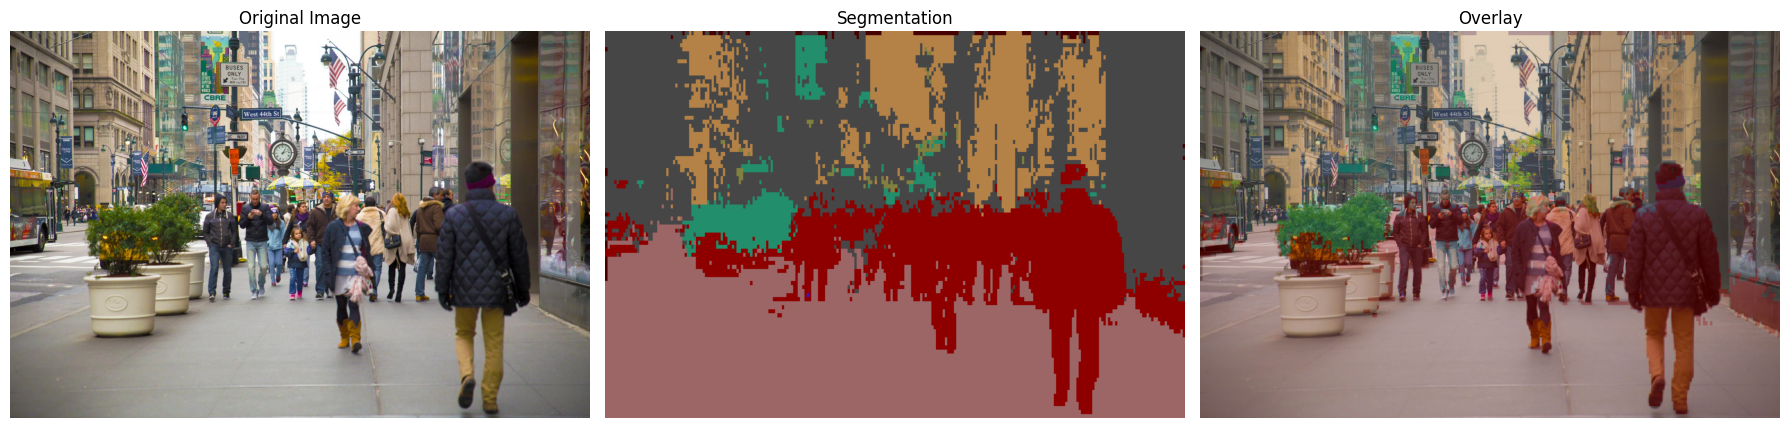

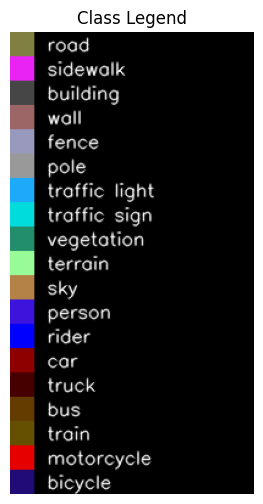

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# For DenseCRF postprocessing
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

# -----------------------------
# Configuration
# -----------------------------
IMG_HEIGHT = 96
IMG_WIDTH  = 256
NUM_CLASSES = 19

# Cityscapes color map: (R, G, B) -> class index
CITYSCAPES_COLOR_MAP = {
    (128, 128, 64): 0,    # road
    (232, 35, 244): 1,    # sidewalk
    (70, 70, 70): 2,      # building
    (156, 102, 102): 3,   # wall
    (153, 153, 190): 4,   # fence
    (153, 153, 153): 5,   # pole
    (30, 170, 250): 6,    # traffic light
    (0, 220, 220): 7,     # traffic sign
    (35, 142, 107): 8,    # vegetation
    (152, 251, 152): 9,   # terrain
    (180, 130, 70): 10,   # sky
    (60, 20, 220): 11,    # person
    (0, 0, 255): 12,      # rider
    (142, 0, 0): 13,      # car
    (70, 0, 0): 14,       # truck
    (100, 60, 0): 15,     # bus
    (100, 80, 0): 16,     # train
    (230, 0, 0): 17,      # motorcycle
    (32, 11, 119): 18,    # bicycle
}

# Create inverse mapping: class index -> (R, G, B)
INV_CITYSCAPES_COLOR_MAP = {v: k for k, v in CITYSCAPES_COLOR_MAP.items()}

# -----------------------------
# Helper Functions
# -----------------------------
def load_image_for_inference(image_path):
    """
    Load an image from disk (BGR), resize to (IMG_WIDTH, IMG_HEIGHT),
    convert to RGB, and normalize to [0,1].
    Returns:
      - image_normalized: (IMG_HEIGHT, IMG_WIDTH, 3) float32
      - orig_size: (orig_height, orig_width)
      - orig_bgr: the original BGR image (for overlay).
    """
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image from {image_path}")
    orig_h, orig_w = bgr.shape[:2]
    bgr_resized = cv2.resize(bgr, (IMG_WIDTH, IMG_HEIGHT))
    rgb_resized = cv2.cvtColor(bgr_resized, cv2.COLOR_BGR2RGB)
    image_normalized = rgb_resized.astype(np.float32) / 255.0
    return image_normalized, (orig_h, orig_w), bgr

def colorize_prediction(pred_class):
    """
    Convert a predicted class map (H, W) to an RGB color image (H, W, 3).
    Uses the inverse CITYSCAPES_COLOR_MAP.
    """
    h, w = pred_class.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, (r, g, b) in INV_CITYSCAPES_COLOR_MAP.items():
        color_mask[pred_class == class_id] = (r, g, b)
    return color_mask

def postprocess_segmentation(pred_class):
    """
    Apply a morphological opening to the predicted class map to remove small noise.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    pred_class_opened = cv2.morphologyEx(pred_class, cv2.MORPH_OPEN, kernel)
    return pred_class_opened

def dense_crf_refine(image_rgb, softmax):
    """
    Refine the segmentation using DenseCRF.
    Args:
      image_rgb: original image in RGB, uint8, shape (H, W, 3)
      softmax: softmax output from the model, shape (H, W, NUM_CLASSES)
               (float32 probabilities)
    Returns:
      refined_pred: refined segmentation as a 2D array of class indices, shape (H, W)
    """
    H, W, _ = image_rgb.shape
    # Ensure softmax is float32 and C-contiguous, then transpose to (NUM_CLASSES, H, W)
    softmax = np.ascontiguousarray(softmax.astype(np.float32)).transpose(2, 0, 1)
    
    d = dcrf.DenseCRF2D(W, H, NUM_CLASSES)
    # Create the unary energy and ensure it is contiguous
    U = np.ascontiguousarray(unary_from_softmax(softmax))
    d.setUnaryEnergy(U)
    
    # Create pairwise bilateral potential (tweak parameters if needed)
    feats = create_pairwise_bilateral(sdims=(10, 10), schan=(13, 13, 13), img=image_rgb, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)
    
    # Run inference (number of iterations can be tuned)
    Q = d.inference(5)
    refined_pred = np.argmax(Q, axis=0).reshape(H, W).astype(np.uint8)
    return refined_pred


def draw_class_legend():
    """
    Display a legend showing the color patch and class name for each class.
    """
    legend_img = np.zeros((NUM_CLASSES*20, 200, 3), dtype=np.uint8)
    font = cv2.FONT_HERSHEY_SIMPLEX
    CLASS_NAMES = [
        "road", "sidewalk", "building", "wall", "fence",
        "pole", "traffic light", "traffic sign", "vegetation", "terrain",
        "sky", "person", "rider", "car", "truck",
        "bus", "train", "motorcycle", "bicycle"
    ]
    for i in range(NUM_CLASSES):
        row_start = i * 20
        row_end = row_start + 20
        (r, g, b) = INV_CITYSCAPES_COLOR_MAP[i]
        legend_img[row_start:row_end, :20] = (b, g, r)  # BGR for OpenCV
        cv2.putText(legend_img, CLASS_NAMES[i], (30, row_start + 15),
                    font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 6))
    plt.imshow(legend_rgb)
    plt.axis("off")
    plt.title("Class Legend")
    plt.show()

def segment_image(model, image_path, use_postprocessing=True, use_crf=True, show_legend=False):
    """
    Run segmentation on a single image and display results:
      - Original image
      - Raw segmentation (color mask)
      - Overlay (original + segmentation)
    Optionally applies morphological postprocessing and DenseCRF refinement.
    Args:
      model: Trained Keras model.
      image_path: Path to test image.
      use_postprocessing: If True, apply morphological opening.
      use_crf: If True, apply DenseCRF refinement.
      show_legend: If True, display a class legend.
    """
    # 1) Load & preprocess the image
    image_norm, (orig_h, orig_w), orig_bgr = load_image_for_inference(image_path)
    input_tensor = np.expand_dims(image_norm, axis=0)  # (1, IMG_HEIGHT, IMG_WIDTH, 3)
    
    # 2) Predict softmax output from model: shape (IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
    softmax_pred = model.predict(input_tensor)[0]
    # Initial prediction by argmax
    pred_class = np.argmax(softmax_pred, axis=-1).astype(np.uint8)
    
    # 3) Optional morphological postprocessing
    if use_postprocessing:
        pred_class = postprocess_segmentation(pred_class)
    
    # 4) Optional DenseCRF refinement
    if use_crf:
        # Use the resized RGB image (values 0-255) for CRF; note image_norm is 0-1 so convert it.
        rgb_resized = (image_norm * 255).astype(np.uint8)
        pred_class = dense_crf_refine(rgb_resized, softmax_pred)
    
    # 5) Colorize segmentation result
    seg_color_small = colorize_prediction(pred_class)
    
    # 6) Resize segmentation mask back to original image size
    seg_color = cv2.resize(seg_color_small, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    
    # 7) Create overlay: convert seg_color from RGB to BGR and blend with original BGR
    seg_color_bgr = cv2.cvtColor(seg_color, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(orig_bgr, 0.6, seg_color_bgr, 0.4, 0)
    
    # 8) Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Segmentation mask (raw colors)
    axes[1].imshow(seg_color)
    axes[1].set_title("Segmentation")
    axes[1].axis("off")
    
    # Overlay image
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    axes[2].imshow(overlay_rgb)
    axes[2].set_title("Overlay")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    if show_legend:
        draw_class_legend()

# -----------------------------
# Load the Trained Model
# -----------------------------
model_path = "model2/best_advanced_model.h5"
model = tf.keras.models.load_model(model_path)

# -----------------------------
# Test on a New Image
# -----------------------------
test_image_path = "C:/Users/MBQ/Desktop/ML Projet V3/dataset/Test/test2.jpg"

# Run segmentation with morphological postprocessing and DenseCRF refinement.
segment_image(model, test_image_path, use_postprocessing=True, use_crf=True, show_legend=True)


## Yolo version 

In [ ]:
from ultralytics import YOLO
import os

# ————————————————
# 1) CONFIGURATION
# ————————————————
PROJECT_DIR = "model/seg_YOLO_MultiClass"

model = YOLO("yolov8n-seg.pt")
model.train(
    data="data.yaml",
    task="segment",
    epochs=30,
    batch=8,
    imgsz=256,
    device="cpu",
    cache="disk",
    workers=4,
    project="model/seg_YOLO_MultiClass",
    name="Projet_ML",
    exist_ok=True
)

# ————————————————
# 3) WEIGHTS
# ————————————————
weights_dir = os.path.join(PROJECT_DIR, "weights")
best_pt  = os.path.join(weights_dir, "best.pt")
last_pt  = os.path.join(weights_dir, "last.pt")

print("→ Best weights: ", best_pt)
print("→ Last weights: ", last_pt)

# ————————————————
# 4) FLASK-FRIENDLY SAVE
# ————————————————
flask_model_path = "C:/Users/MBQ/Desktop/ML Projet Test/App Projet ML/static/model"
YOLO("C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/model/seg_YOLO_MultiClass/Projet_ML/weights/best.pt").save(flask_model_path)
print("→ Saved inference model →", flask_model_path)


New https://pypi.org/project/ultralytics/8.3.130 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.128  Python-3.8.7 torch-1.13.1+cpu CPU (Intel Pentium Silver N5030 1.10GHz)
WARNING Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Pr

train: Scanning C:\Users\MBQ\Desktop\ML Projet Test\ML Projet V3\dataset\train\img.cache... 2975 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2975/2975 [00:00<?, ?it/s]
train: Caching images (1.1GB Disk): 100%|██████████| 2975/2975 [00:00<00:00, 4052.87it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.30.1 ms, read: 127.524.4 MB/s, size: 184.5 KB)


val: Scanning C:\Users\MBQ\Desktop\ML Projet Test\ML Projet V3\dataset\val\img.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
val: Caching images (0.2GB Disk): 100%|██████████| 500/500 [00:00<00:00, 4263.72it/s]


Plotting labels to model\seg_YOLO_MultiClass\Projet_ML\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to model\seg_YOLO_MultiClass\Projet_ML
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.871      3.458      2.834      1.361        380        256: 100%|██████████| 372/372 [45:13<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:08<00:00,  4.01s/it]


                   all        500      41211      0.484     0.0716     0.0844      0.048      0.465     0.0667     0.0771     0.0344

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.605      2.933      1.404      1.224        362        256: 100%|██████████| 372/372 [36:15<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:38<00:00,  3.08s/it]


                   all        500      41211      0.493     0.0914     0.0987     0.0562      0.463     0.0837     0.0901     0.0404

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.507      2.812      1.215      1.191        287        256: 100%|██████████| 372/372 [32:39<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:44<00:00,  3.27s/it]


                   all        500      41211      0.425      0.101      0.104     0.0587      0.369     0.0907     0.0924     0.0403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.452      2.754       1.14      1.169        411        256: 100%|██████████| 372/372 [42:11<00:00,  6.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:00<00:00,  3.77s/it]


                   all        500      41211      0.424      0.105      0.109     0.0623      0.386     0.0978        0.1     0.0445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.419      2.698      1.098      1.151        352        256: 100%|██████████| 372/372 [38:50<00:00,  6.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:49<00:00,  3.43s/it]


                   all        500      41211      0.426      0.107      0.111     0.0645      0.412     0.0955        0.1      0.045

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.394      2.656      1.069       1.14        330        256: 100%|██████████| 372/372 [35:56<00:00,  5.80s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:48<00:00,  3.40s/it]


                   all        500      41211      0.423      0.111      0.113     0.0656      0.383      0.102      0.103     0.0465

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.374      2.627       1.05      1.132        333        256: 100%|██████████| 372/372 [36:27<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:48<00:00,  3.40s/it]


                   all        500      41211      0.436      0.109      0.115      0.067      0.404        0.1      0.106     0.0486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.366      2.612      1.032      1.125        372        256: 100%|██████████| 372/372 [34:50<00:00,  5.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:44<00:00,  3.26s/it]


                   all        500      41211      0.421      0.111      0.117      0.069      0.391      0.102      0.106     0.0479

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.347      2.601      1.017      1.118        372        256: 100%|██████████| 372/372 [37:57<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:01<00:00,  3.79s/it]


                   all        500      41211      0.423      0.117      0.119     0.0697      0.379      0.106      0.108     0.0492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.338      2.574     0.9996      1.114        310        256: 100%|██████████| 372/372 [38:58<00:00,  6.29s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:12<00:00,  4.15s/it]


                   all        500      41211      0.416      0.116      0.121     0.0703      0.384      0.106       0.11     0.0498

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.329      2.558     0.9958      1.109        408        256: 100%|██████████| 372/372 [41:18<00:00,  6.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:12<00:00,  4.16s/it]


                   all        500      41211      0.433      0.117      0.121     0.0714      0.408      0.108      0.112     0.0515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.322      2.555     0.9866      1.107        390        256: 100%|██████████| 372/372 [37:47<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:45<00:00,  3.28s/it]


                   all        500      41211       0.43      0.117      0.122      0.072      0.409      0.108      0.113     0.0525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.315      2.526      0.978      1.103        371        256: 100%|██████████| 372/372 [40:43<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:11<00:00,  4.12s/it]


                   all        500      41211      0.443      0.117      0.123     0.0733      0.404      0.109      0.113     0.0523

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.298      2.506     0.9664      1.098        281        256: 100%|██████████| 372/372 [38:38<00:00,  6.23s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


                   all        500      41211      0.437       0.12      0.124     0.0733      0.406       0.11      0.115     0.0528

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G        1.3      2.499     0.9596      1.096        402        256: 100%|██████████| 372/372 [46:04<00:00,  7.43s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:06<00:00,  3.94s/it]


                   all        500      41211      0.428       0.12      0.125     0.0736      0.403       0.11      0.115     0.0523

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.287      2.479     0.9509      1.092        474        256: 100%|██████████| 372/372 [40:24<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:11<00:00,  4.10s/it]


                   all        500      41211      0.442      0.118      0.125     0.0749      0.403      0.111      0.117     0.0537

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.284      2.472     0.9451      1.089        387        256: 100%|██████████| 372/372 [42:56<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:05<00:00,  3.94s/it]


                   all        500      41211      0.441      0.118      0.124     0.0753       0.41       0.11      0.116     0.0539

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G       1.28      2.478     0.9357      1.087        411        256: 100%|██████████| 372/372 [43:25<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:23<00:00,  4.48s/it]


                   all        500      41211       0.44      0.121      0.127     0.0755      0.411      0.111      0.117     0.0535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.267      2.453     0.9286      1.085        311        256: 100%|██████████| 372/372 [42:18<00:00,  6.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:47<00:00,  3.35s/it]


                   all        500      41211      0.441      0.123      0.129     0.0773      0.399      0.113      0.118     0.0548

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.263       2.43     0.9242      1.083        298        256: 100%|██████████| 372/372 [38:44<00:00,  6.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:50<00:00,  3.45s/it]


                   all        500      41211      0.437      0.123      0.128      0.077      0.396      0.114      0.119     0.0553
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.316      2.511      1.001      1.101        182        256: 100%|██████████| 372/372 [9:01:32<00:00, 87.35s/it]      
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:56<00:00,  3.63s/it]


                   all        500      41211       0.35      0.121       0.13     0.0779      0.325      0.111       0.12     0.0555

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.289      2.476      0.962      1.091        122        256: 100%|██████████| 372/372 [1:00:56<00:00,  9.83s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:52<00:00,  3.52s/it]


                   all        500      41211      0.341      0.128       0.13      0.078      0.294      0.117      0.119     0.0555

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.275      2.442     0.9456      1.086        174        256: 100%|██████████| 372/372 [32:05<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:52<00:00,  5.38s/it]


                   all        500      41211      0.366      0.124       0.13     0.0786      0.326      0.115      0.121     0.0559

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.272      2.447     0.9381      1.081        210        256: 100%|██████████| 372/372 [37:46<00:00,  6.09s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:33<00:00,  4.81s/it]


                   all        500      41211       0.35      0.125       0.13     0.0785      0.304      0.115       0.12     0.0561

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.265      2.433     0.9267      1.079        235        256: 100%|██████████| 372/372 [38:45<00:00,  6.25s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:41<00:00,  5.05s/it]


                   all        500      41211      0.363      0.125      0.131     0.0784      0.316      0.117      0.121     0.0562

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.254      2.422     0.9247      1.076        175        256: 100%|██████████| 372/372 [50:59<00:00,  8.22s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [04:18<00:00,  8.08s/it]


                   all        500      41211      0.366      0.126      0.131     0.0795      0.329      0.116      0.122     0.0567

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.247      2.417     0.9185       1.07        230        256: 100%|██████████| 372/372 [1:05:48<00:00, 10.61s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:13<00:00,  4.17s/it]


                   all        500      41211      0.347      0.126      0.132     0.0794      0.307      0.117      0.121     0.0566

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G       1.24      2.393     0.9056      1.067        200        256: 100%|██████████| 372/372 [1:05:59<00:00, 10.64s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:32<00:00,  4.78s/it]


                   all        500      41211      0.344      0.125      0.131     0.0792      0.316      0.115      0.121      0.056

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.232      2.395     0.8986      1.064        191        256: 100%|██████████| 372/372 [1:11:25<00:00, 11.52s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:30<00:00,  2.82s/it]


                   all        500      41211      0.356      0.127      0.132       0.08      0.321      0.117      0.121     0.0566

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G       1.23      2.387     0.9001      1.062        159        256: 100%|██████████| 372/372 [1:09:24<00:00, 11.20s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:58<00:00,  3.71s/it]


                   all        500      41211       0.35      0.127      0.132     0.0803      0.327      0.118      0.122      0.057

30 epochs completed in 31.543 hours.
Optimizer stripped from model\seg_YOLO_MultiClass\Projet_ML\weights\last.pt, 6.7MB
Optimizer stripped from model\seg_YOLO_MultiClass\Projet_ML\weights\best.pt, 6.7MB

Validating model\seg_YOLO_MultiClass\Projet_ML\weights\best.pt...
Ultralytics 8.3.128  Python-3.8.7 torch-1.13.1+cpu CPU (Intel Pentium Silver N5030 1.10GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,260,209 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/32 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 1/32 [00:03<01:36,  3.10s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6%|▋         | 2/32 [00:09<02:25,  4.86s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:48<00:00,  3.39s/it]


                   all        500      41211      0.353      0.127      0.132     0.0802      0.327      0.118      0.122      0.057
 road_sidewalk_parking        485       5146      0.484       0.19      0.207      0.157      0.446      0.187      0.205      0.133
               traffic        467       3362      0.238     0.0306     0.0331     0.0112      0.198      0.028     0.0311     0.0118
                person        431       3634      0.339      0.105      0.105     0.0435      0.268     0.0889      0.087     0.0305
               vehicle        495       8697      0.447      0.123      0.143     0.0841        0.4      0.117       0.14     0.0696
                  pole        496      10267       0.34      0.134      0.127     0.0655      0.296      0.127      0.118     0.0488
             structure        159        552      0.216     0.0543     0.0351     0.0218      0.214     0.0567     0.0321     0.0149
                ground        248        906      0.104     0.0011   

RuntimeError: File C:/Users/MBQ/Desktop/ML Projet Test/App Projet ML/static/model cannot be opened.

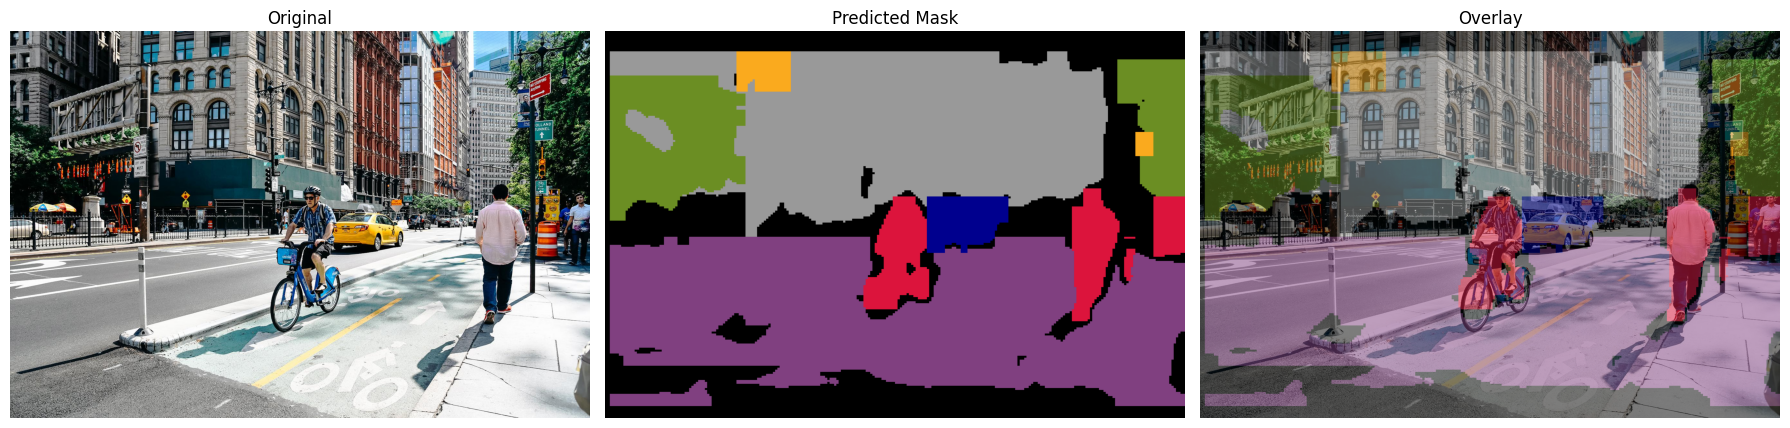

In [3]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ───── YOUR TRAINED PALETTE ─────
PALETTE = {
    0: (  0,   0,   0),  # static
    1: (128,  64, 128),  # road_sidewalk_parking
    2: (250, 170,  30),  # traffic
    3: (220,  20,  60),  # person
    4: (  0,   0, 142),  # vehicle
    5: (153, 153, 153),  # pole
    6: ( 70,  70,  70),  # structure
    7: ( 81,   0,  81),  # ground
    8: (107, 142,  35),  # vegetation
    9: (152, 251, 152),  # terrain
   10: ( 70, 130, 180),  # sky
}

def infer_and_show(image_path, model_path="C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/model/seg_YOLO_MultiClass/Projet_ML/weights/best.pt", conf=0.25):
    # Load model
    model = YOLO(model_path)
    # Read original
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]
    # Inference
    results = model.predict(image_path, conf=conf, verbose=False)
    r = results[0]
    masks = r.masks.data.cpu().numpy()       # (N, H_net, W_net)
    classes = r.boxes.cls.cpu().numpy().astype(int)  # (N,)

    # Build semantic map
    semantic = np.zeros((H, W), dtype=np.uint8)
    for mask_i, cls_id in zip(masks, classes):
        # binary mask (float→bool or already uint8)
        bin_mask = (mask_i > 0.5).astype(np.uint8)
        # resize back to original
        bin_mask = cv2.resize(bin_mask, (W, H), interpolation=cv2.INTER_NEAREST)
        semantic[bin_mask == 1] = cls_id

    # Colorize
    color_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for cid, col in PALETTE.items():
        color_mask[semantic == cid] = col

    # Overlay
    alpha = 0.5
    overlay = (img_rgb * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # Display
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(color_mask)
    axs[1].set_title("Predicted Mask"); axs[1].axis("off")
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay"); axs[2].axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # adjust this path to your test image
    TEST_IMG = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset/Test/test3.jpg"
    # TEST_IMG = r"C:/Users/MBQ/Desktop/ML Projet Test/ML Projet V3/dataset/Test/test2.jpg"
    infer_and_show(TEST_IMG)
